In [1]:
#load all packages
import tensorflow as tf
from tensorflow.keras import layers, models
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.model_selection import train_test_split
from keras import metrics
import keras.backend as K


In [2]:
#load csv data to get the ID and class/target
# win and mac pathing is different (you have to add YOUR correct path)
#this is for windows
metaData = pd.read_csv("F:\MRI_class\data\oasis_cross_sectional.csv")
#this is for mac
#metaData = pd.read_csv("~/neuefische/alzheimer-classification/data/oasis_cross_sectional.csv")
metaData = metaData[metaData.Age >= 50]
metaData = metaData[["ID","CDR"]]

# imputing missing 0
metaData.CDR[metaData.CDR.isna() == True] = 0

In [3]:
#get file names
path = "F:\MRI_class\data\horizontal_masked"
#path = "/Users/stephanbremser/neuefische/alzheimer-classification/data/horizontal_masked"#"~/neuefische/alzheimer-classification/data/horizontal_masked"
path_list = os.listdir(path)

In [4]:
#create file list matching the path_list
t = pd.DataFrame(path_list)

#merge metadata dataframe with file list on ID
f = lambda x: x[0:13] #merge on first 13 letters (eg "OAS1_0001_MR1")
t["ID"]=t[0].apply(f)

metaData = pd.merge(metaData, t,on="ID", how="left")
metaData = metaData.rename(columns={0:"file"})

In [5]:
metaData.head()

,ID,CDR,file
0,OAS1_0001_MR1,0.0,OAS1_0001_MR1_mpr_n4_anon_111_t88_masked_gfc_t...
1,OAS1_0002_MR1,0.0,OAS1_0002_MR1_mpr_n4_anon_111_t88_masked_gfc_t...
2,OAS1_0003_MR1,0.5,OAS1_0003_MR1_mpr_n4_anon_111_t88_masked_gfc_t...
3,OAS1_0010_MR1,0.0,OAS1_0010_MR1_mpr_n4_anon_111_t88_masked_gfc_t...
4,OAS1_0011_MR1,0.0,OAS1_0011_MR1_mpr_n4_anon_111_t88_masked_gfc_t...


In [6]:
X = metaData["file"]
y = metaData["CDR"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=10)

In [8]:
X_train = X_train.reset_index()
X_test = X_test.reset_index()

In [9]:
# replace to have only 0 and 1 in target
y_train.replace(0.5,1,inplace=True)
y_test.replace(0.5,1,inplace=True)
y_train.replace(2,1,inplace=True)
y_test.replace(2,1,inplace=True)

In [10]:
#train
#using X_train IDs to get the images and convert to 4D array

checker = 0
for t in range(0,len(X_train.file)):
    
    #iteration check
    if t+1 > len(X_train.file)-1:
        break
    
    #image1
    temp_path = path+"\\"+X_train.file[t]
    image1 = tf.keras.preprocessing.image.load_img(temp_path)
    input_arr1 = tf.keras.preprocessing.image.img_to_array(image1)
    input_arr1 = input_arr1[:,:,:,np.newaxis]
    
    #image2
    temp_path = path+"\\"+X_train.file[t+1]
    image2 = tf.keras.preprocessing.image.load_img(temp_path)
    input_arr2 = tf.keras.preprocessing.image.img_to_array(image2)
    input_arr2 = input_arr2[:,:,:,np.newaxis]

    #concatenate
    if t == 0:
        images = np.concatenate((input_arr1,input_arr2),axis = 3)
    
    if t > 0:
        images = np.concatenate((images,input_arr2),axis = 3)

    
images = np.moveaxis(images,3,0)
images_train = images


In [11]:
images_train = images_train[:,:,:,0]

In [12]:
for t in range(0,len(images_train)):
    images_train[t,:,:] = ((images_train[t,:,:] - np.mean(images_train[t,:,:])) /np.std(images_train[t,:,:]))

In [13]:
#test
#using X_test IDs to get the images and convert to 4D array

checker = 0
for t in range(0,len(X_test.file)):
    
    #iteration check
    if t+1 > len(X_test.file)-1:
        break

    #image1
    temp_path = path+"\\"+X_test.file[t]
    image1 = tf.keras.preprocessing.image.load_img(temp_path)
    input_arr1 = tf.keras.preprocessing.image.img_to_array(image1)
    input_arr1 = input_arr1[:,:,:,np.newaxis]
    
    #image2
    temp_path = path+"\\"+X_test.file[t+1]
    image2 = tf.keras.preprocessing.image.load_img(temp_path)
    input_arr2 = tf.keras.preprocessing.image.img_to_array(image2)
    input_arr2 = input_arr2[:,:,:,np.newaxis]

    #concatenate
    if t == 0:
        images = np.concatenate((input_arr1,input_arr2),axis = 3)
    
    if t > 0:
        images = np.concatenate((images,input_arr2),axis = 3)

    
images = np.moveaxis(images,3,0)
images_test = images

In [14]:
images_test = images_test[:,:,:,1]

In [15]:
for t in range(0,len(images_test)):
    images_test[t,:,:] = ((images_test[t,:,:] - np.mean(images_test[t,:,:])) /np.std(images_test[t,:,:]))

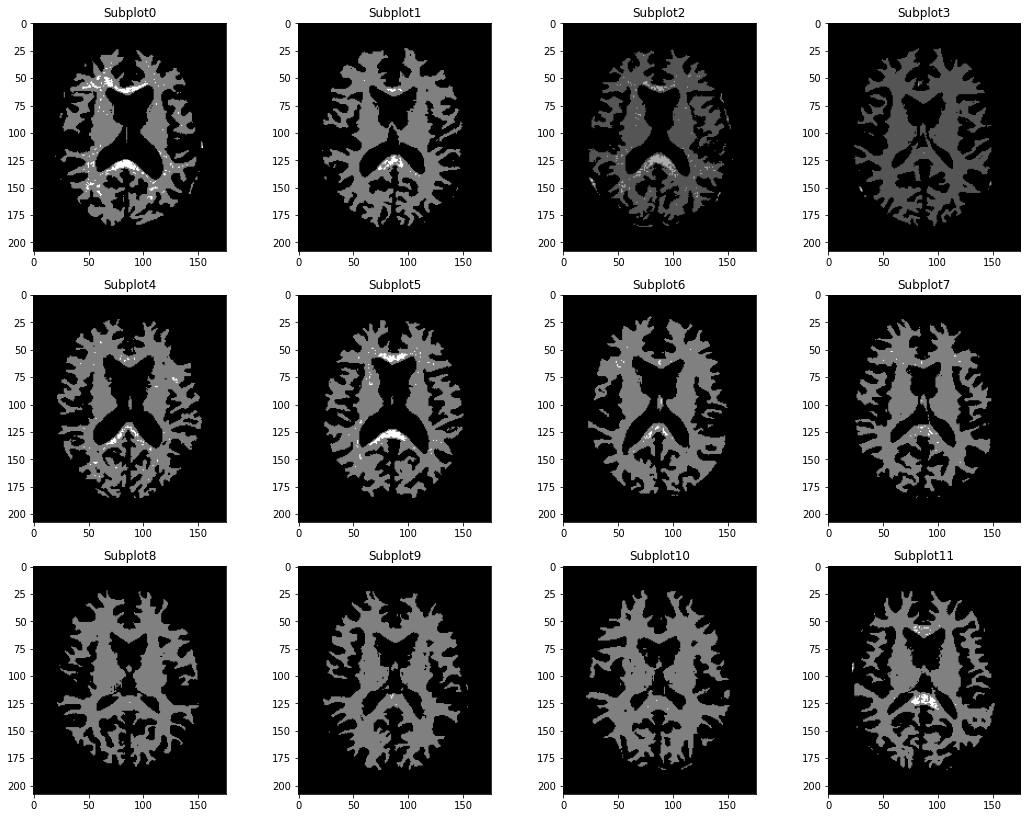

In [16]:
#visualization of couple brains
cols= 4
rows = 4
axes = []
width = 1000
height = 1000

fig = plt.figure(figsize=(15, 15))

for a in range(0,12):
    b = images_test[a].astype('uint8')
    axes.append( fig.add_subplot(rows, cols, a+1) )
    subplot_title=("Subplot"+str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b,cmap="gray")
fig.tight_layout()
plt.show()

In [ ]:
asd

In [17]:
#iniziating model architecture
model = models.Sequential()
model.add(layers.Conv2D(100, (3, 3), activation='relu', input_shape=(208, 176, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [18]:
#add dense layes to conv layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation="sigmoid"))


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 206, 174, 100)     1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 103, 87, 100)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 101, 85, 64)       57664     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 42, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 40, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 122880)            0

In [20]:
EPOCHS = 30
BATCH_SIZE = 50
STEPS_PER_EPOCH = len(images_train) // BATCH_SIZE


In [21]:
#function from the WEB. Just to be able to print F1 score since it is not available in keras metrics

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [22]:
#compiling the model architecture and start fit

model.compile(optimizer='adam',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss="binary_crossentropy",
              metrics=['accuracy',
              
              metrics.Precision(), metrics.Recall(), get_f1])

history = model.fit(images_train, y_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_split=0.15)
                    

Epoch 1/30
3/3 [==============================] - 5s 2s/step - loss: 1.4224 - accuracy: 0.5918 - precision: 0.5132 - recall: 0.6290 - get_f1: 0.4304 - val_loss: 1.6862 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_get_f1: 0.0000e+00
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 0.9736 - accuracy: 0.5510 - precision: 0.4730 - recall: 0.5645 - get_f1: 0.4207 - val_loss: 0.7211 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_get_f1: 0.0000e+00
Epoch 3/30
3/3 [==============================] - 5s 2s/step - loss: 0.6708 - accuracy: 0.6259 - precision: 0.6207 - recall: 0.2903 - get_f1: 0.2500 - val_loss: 0.6631 - val_accuracy: 0.5385 - val_precision: 1.0000 - val_recall: 0.0769 - val_get_f1: 0.1429
Epoch 4/30
3/3 [==============================] - 5s 2s/step - loss: 0.6407 - accuracy: 0.6463 - precision: 0.6923 - recall: 0.2903 - get_f1: 0.3644 - val_loss: 0.6212 - val_accuracy: 0.5769 - val_precisio

2/2 - 0s - loss: 1.4482 - accuracy: 0.6207 - precision: 0.5652 - recall: 0.5200 - get_f1: 0.5420 - 384ms/epoch - 192ms/step


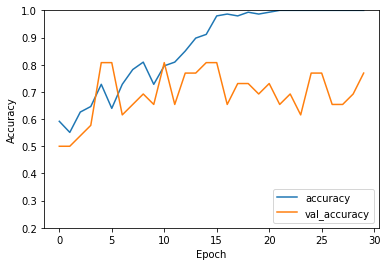

In [23]:
#print val vs accuracy

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

test_loss, test_acc, z,z1,z2  = model.evaluate(images_test,  y_test, verbose=2)

In [24]:
'''# get specific layer output - TAKES some time. Layer 7 is the output layer
get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[3].output])
layer_output = get_layer_output([images_train])[0]'''

'# get specific layer output - TAKES some time. Layer 7 is the output layer\nget_layer_output = K.function([model.layers[0].input],\n                                  [model.layers[3].output])\nlayer_output = get_layer_output([images_train])[0]'

In [25]:
#!mkdir -p saved_model
#model.save("saved_model/model1")